Refrence: https://keras.io/examples/vision/siamese_network/, https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/vision/ipynb/siamese_network.ipynb

In [ ]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
data_url = "/content/drive/MyDrive/AI_DataSets/siamese_network/faces"
cls_url = data_url+"/classification_data"
test_data_url = cls_url+"/test_data"
train_data_url = cls_url+"/train_data"
val_data_url = cls_url+"/val_data"

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("faber24/lcc-fasd")

print("Path to dataset files:", path)

100%|██████████| 4.84G/4.84G [02:05<00:00, 41.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/faber24/lcc-fasd/versions/1


In [ ]:
import os

real_paths, spoof_paths = [], []

for root, dirs, files in os.walk(path):
    for f in files:
        low = f.lower()
        full = os.path.join(root, f)
        if "real" in low:
            real_paths.append(full)
        elif "spoof" in low:
            spoof_paths.append(full)

print(f"{len(real_paths)} real files, {len(spoof_paths)} spoof files")


314 real files, 7266 spoof files


In [ ]:
import tensorflow as tf
import os

ROOT = "/root/.cache/kagglehub/datasets/faber24/lcc-fasd/versions/1/LCC_FASD/LCC_FASD_development"
DIM  = 64
BATCH = 32

real_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(ROOT, "real"),
    labels=None,
    shuffle=False,
    image_size=(DIM, DIM),
    batch_size=BATCH,
)

spoof_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(ROOT, "spoof"),
    labels=None,
    shuffle=False,
    image_size=(DIM, DIM),
    batch_size=BATCH,
)


Found 405 files.
Found 2543 files.


I need to maximize my real images combos!  
https://www.tensorflow.org/addons/api_docs/python/tfa/losses/TripletSemiHardLoss

In [ ]:
print(real_ds.as_numpy_iterator[0])

TypeError: 'method' object is not subscriptable

In [ ]:
import os
import shutil

download_path = "/path/to/lcc-fasd"

real_dir  = os.path.join(download_path, "real")
spoof_dir = os.path.join(download_path, "spoof")

os.makedirs(real_dir,  exist_ok=True)
os.makedirs(spoof_dir, exist_ok=True)

for fname in os.listdir(download_path):
    src = os.path.join(download_path, fname)
    if not os.path.isfile(src):
        continue  # skip any sub-folders

    lower = fname.lower()
    if "real_" in lower:
        new_name = fname.replace("real_", "", 1)
        dst = os.path.join(real_dir, new_name)
        shutil.copy(src, dst)

    elif "spoof_" in lower:
        new_name = fname.replace("spoof_", "", 1)
        dst = os.path.join(spoof_dir, new_name)
        shutil.copy(src, dst)


In [ ]:
print(len(real_dir))
print(len(spoof_dir))

22
23


In [ ]:
import os
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D

In [ ]:
import os
import random
import tensorflow as tf
from collections import defaultdict

In [ ]:
def preprocess_image(filename):

    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, DIM) #just incase
    return image

def preprocess_triplets(anchor, positive, negative=None):
    if negative is None:
      return (
        preprocess_image(anchor),
        preprocess_image(positive),
        )
    return (
      preprocess_image(anchor),
      preprocess_image(positive),
      preprocess_image(negative),
      )
# def get_random_excluding(x=0,y=any,z=CATAGORY_LEN):
#   return random.rand(random.randint(0,y-1),random.randint(y+1,z))

# #add hoc method to get tripplets
# def get_triplet():
#   anchor_catagorical_index = random.randint(0,CATAGORY_LEN)
#   negative_catagorical_index = get_random_excluding(anchor_catagorical_index)

#   anchor_index = random.randint(0,len(train_imgs_cata[anchor_catagorical_index])-1)
#   anchor = train_imgs_cata[anchor_catagorical_index][anchor_index]
#   positive = train_imgs_cata[anchor_catagorical_index][get_random_excluding(anchor_index)]
#   negative = train_imgs_cata[negative_catagorical_index][random.randint(0,len(train_imgs_cata[negative_catagorical_index])-1)]
#   return preprocess_triplets(anchor,positive,negative)


In [ ]:
DIM=(64,64)

In [ ]:
import os
import random
from itertools import combinations

def get_triplets(url, cap=None):
    imgs_cata = {}
    train_dirs = sorted(os.listdir(url))
    for i, cls_name in enumerate(train_dirs):
        cls_dir = os.path.join(url, cls_name)
        imgs_cata[i] = [
            os.path.join(cls_dir, fname)
            for fname in sorted(os.listdir(cls_dir))
        ]

    triplet_paths = {}
    for key, imgs in imgs_cata.items():
        neg_keys = [k for k in imgs_cata if k != key]
        cap_slice = imgs if cap is None else imgs[:cap]

        triplet_paths[key] = []
        for a, p in combinations(cap_slice, 2):
            neg_cls = random.choice(neg_keys)
            n = random.choice(imgs_cata[neg_cls])
            triplet_paths[key].append((a, p, n))

    return triplet_paths


In [ ]:
def extract_name(path, trim=3,symbol='_'):
    filename = os.path.basename(path)
    name, _ = os.path.splitext(filename)
    #trim 3 from the back, because of data set pattern
    return name.rsplit(symbol, trim)[0]

In [ ]:
import os

def extract_id(path):
    stem = os.path.splitext(os.path.basename(path))[0]
    for part in stem.split('_'):
        if part.startswith('id'):
            return part

    raise ValueError(stem)

id147


In [ ]:
import random
from itertools import combinations

# the cap can't be set more then the minimum amount of samples for the smallest class
# generic helper function to create triplets from duo url dictionarys (anchor and positive)

def get_triplets(url, cap=None):

  #creation of catagorical url dict
  imgs_cata = {}
  train_dirs = os.listdir(url)
  for i, dir in enumerate(train_dirs):
    imgs_cata[i] = []
    dir_url = url+"/"+dir
    _dir = os.listdir(dir_url)
    for img in _dir:
      imgs_cata[i].append(dir_url+"/"+img)

  #creating the processed triplets
  triplets_dict = {}
  for key,imgs in imgs_cata.items():
    neg_keys = list(imgs_cata.keys())
    neg_keys.remove(key)
    triplets_dict[key] = []
    for a, p in combinations(imgs[:cap], 2):
      neg_key = random.choice(neg_keys)
      triplets = (a,p, random.choice(imgs_cata[neg_key]))
      triplets_dict[key].append(triplets)

  return triplets_dict

In [ ]:
import random
from itertools import combinations

# the cap can't be set more then the minimum amount of samples for the smallest class
# generic helper function to create triplets from duo url dictionarys (anchor and positive)

def get_img_catagorised_urls(url, cap=None):
  os.listdir(url)
  # spoof_path = os.path.join(url,"/spoof")
  # real_path = os.path.join(url,"/real")
  #creation of catagorical url dict
  imgs_cata = {}
  train_dirs = os.listdir(url)
  print(train_dirs)
  for dir in train_dirs:
    imgs_cata[dir] = []
    for urls in os.listdir(url+"/"+ dir):
      imgs_cata[dir].append(url+"/"+dir+"/"+urls)

  # #creating the processed triplets
  # triplets_dict = {}
  # for key,imgs in imgs_cata.items():
  #   neg_keys = list(imgs_cata.keys())
  #   neg_keys.remove(key)
  #   triplets_dict[key] = []
  #   for a, p in combinations(imgs[:cap], 2):
  #     neg_key = random.choice(neg_keys)
  #     triplets = (a,p, random.choice(imgs_cata[neg_key]))
  #     triplets_dict[key].append(triplets)

  return imgs_cata

now i have the directory catagorical, i have to match by name

In [ ]:
url_dict = get_img_catagorised_urls("/root/.cache/kagglehub/datasets/faber24/lcc-fasd/versions/1/LCC_FASD/LCC_FASD_development")

['spoof', 'real']


In [ ]:
print(url_dict['real'])

['/root/.cache/kagglehub/datasets/faber24/lcc-fasd/versions/1/LCC_FASD/LCC_FASD_development/real/MSIGT72_id164_s0_30.png', '/root/.cache/kagglehub/datasets/faber24/lcc-fasd/versions/1/LCC_FASD/LCC_FASD_development/real/YOUTUBE_id115_s1_105.png', '/root/.cache/kagglehub/datasets/faber24/lcc-fasd/versions/1/LCC_FASD/LCC_FASD_development/real/YOUTUBE_id123_s0_30.png', '/root/.cache/kagglehub/datasets/faber24/lcc-fasd/versions/1/LCC_FASD/LCC_FASD_development/real/YOUTUBE_id124_s0_90.png', '/root/.cache/kagglehub/datasets/faber24/lcc-fasd/versions/1/LCC_FASD/LCC_FASD_development/real/YOUTUBE_id117_s0_15.png', '/root/.cache/kagglehub/datasets/faber24/lcc-fasd/versions/1/LCC_FASD/LCC_FASD_development/real/YOUTUBE_id42_s1_83.png', '/root/.cache/kagglehub/datasets/faber24/lcc-fasd/versions/1/LCC_FASD/LCC_FASD_development/real/IPHONE8B_id81_s0_105.png', '/root/.cache/kagglehub/datasets/faber24/lcc-fasd/versions/1/LCC_FASD/LCC_FASD_development/real/YOUTUBE_id43_s1_150.png', '/root/.cache/kagglehu

In [ ]:
# bulding the citionary of urls based on the name classes
for key,urls in url_dict.items():
  for url in urls:
    name = extract_name(url)
    url_dict[key][name].append(url)

# print(url_dict.keys())

TypeError: list indices must be integers or slices, not str

In [ ]:
from collections import defaultdict

data_dict = defaultdict(lambda: {'real': [], 'spoof': []})

real_paths = url_dict['real']
spoof_paths = url_dict['spoof']
for p in real_paths:
    name = extract_id(p)
    print(name)
    data_dict[name]['real'].append(p)

for p in spoof_paths:
    name = extract_id(p)
    data_dict[name]['spoof'].append(p)


for buckets in data_dict.values():
    buckets['real'].sort()
    buckets['spoof'].sort()

for name, buckets in data_dict.items():
    print(f"{name}: {len(buckets['real'])} real, {len(buckets['spoof'])} spoof")



id164
id115
id123
id124
id117
id42
id81
id43
id43
id164
id124
id0
id117
id161
id81
id115
id122
id124
id0
id0
id169
id0
id161
id124
id116
id0
id0
id115
id43
id5
id124
id39
id118
id43
id116
id147
id123
id0
id12
id5
id39
id0
id0
id116
id161
id120
id0
id116
id115
id117
id121
id39
id12
id48
id116
id48
id121
id119
id9
id43
id116
id12
id48
id5
id43
id39
id119
id9
id12
id48
id169
id5
id0
id164
id119
id116
id115
id115
id48
id120
id0
id81
id9
id169
id120
id43
id116
id48
id119
id124
id12
id116
id0
id48
id42
id5
id118
id115
id5
id161
id42
id123
id39
id9
id161
id5
id116
id115
id9
id169
id9
id122
id118
id115
id0
id48
id119
id5
id9
id12
id42
id0
id9
id115
id115
id115
id0
id48
id152
id118
id0
id164
id29
id0
id124
id5
id29
id115
id48
id48
id147
id115
id0
id164
id124
id48
id119
id9
id9
id12
id48
id48
id152
id9
id152
id81
id9
id29
id48
id118
id48
id12
id5
id116
id119
id48
id119
id0
id116
id117
id42
id43
id42
id5
id48
id152
id81
id161
id12
id123
id147
id115
id81
id29
id164
id5
id169
id81
id12
id121
id39
i

we mix the data set with a limited pool of identitys like theres 9 identitys and they have tones of images, but because theres only 9 clases if we choose spoofing images at random its likely we will have a negative that is of the same identity and not! so it gets the best of both worlds!

to start I will try a 50/50 split for negatives, where 50 percent spoofs are of same idnetity and other 50 is of ifferent idenitity but still spoof



In [ ]:
to_remove = [
    name
    for name, buckets in data_dict.items()
    if not buckets['real'] or not buckets['spoof']
]

for name in to_remove:
    del data_dict[name]

for name, buckets in data_dict.items():
    print(f"{name}: {len(buckets['real'])} real, {len(buckets['spoof'])} spoof")

    print(buckets['real'][0])
    print(buckets['spoof'][0])


id42: 12 real, 316 spoof
/root/.cache/kagglehub/datasets/faber24/lcc-fasd/versions/1/LCC_FASD/LCC_FASD_development/real/YOUTUBE_id42_s0_105.png
/root/.cache/kagglehub/datasets/faber24/lcc-fasd/versions/1/LCC_FASD/LCC_FASD_development/spoof/YOUTUBE_AA6000_HUAWEIY9_id42_s0_105.png
id43: 20 real, 494 spoof
/root/.cache/kagglehub/datasets/faber24/lcc-fasd/versions/1/LCC_FASD/LCC_FASD_development/real/YOUTUBE_id43_s0_105.png
/root/.cache/kagglehub/datasets/faber24/lcc-fasd/versions/1/LCC_FASD/LCC_FASD_development/spoof/YOUTUBE_AAR7_IPHONE4S_id43_s0_111.png
id0: 40 real, 416 spoof
/root/.cache/kagglehub/datasets/faber24/lcc-fasd/versions/1/LCC_FASD/LCC_FASD_development/real/FT720P_id0_s0_105.png
/root/.cache/kagglehub/datasets/faber24/lcc-fasd/versions/1/LCC_FASD/LCC_FASD_development/spoof/FT720P_G780_REDMI4X_id0_s0_105.png
id5: 20 real, 139 spoof
/root/.cache/kagglehub/datasets/faber24/lcc-fasd/versions/1/LCC_FASD/LCC_FASD_development/real/FT720P_id5_s0_105.png
/root/.cache/kagglehub/datase

In [ ]:

import itertools
import random
from itertools import islice

def group_triplets(val, cap=None):
    all_spoofs = [neg for buckets in data_dict.values() for neg in buckets['spoof']]

    train_dict = {}
    val_dict   = {}

    for name, buckets in data_dict.items():
        reals = buckets['real']

        triplet_gen = (
            (anchor, positive, neg)
            for (anchor, positive) in itertools.permutations(reals, 2)
            for neg in all_spoofs
        )
        if cap is not None:
            triplets = list(islice(triplet_gen, cap))
        else:
            triplets = list(triplet_gen)

        random.shuffle(triplets)

        if val > 0:
            val_count = min(val, len(triplets))
            val_subset   = triplets[:val_count]
            train_subset = triplets[val_count:]
        else:
            val_subset   = []
            train_subset = triplets

        train_dict[name] = train_subset
        val_dict[name]   = val_subset

    for name in data_dict:
        t = len(train_dict[name])
        v = len(val_dict[name])
        cap_info = f" (capped @ {cap})" if cap else ""
        print(f"{name}: {t} train, {v} val triplets{cap_info}")

    return train_dict, val_dict



In [ ]:
train_paths, val_paths = group_triplets(100,cap=1100)

id42: 1000 train, 100 val triplets (capped @ 1100)
id43: 1000 train, 100 val triplets (capped @ 1100)
id0: 1000 train, 100 val triplets (capped @ 1100)
id5: 1000 train, 100 val triplets (capped @ 1100)
id39: 1000 train, 100 val triplets (capped @ 1100)
id12: 1000 train, 100 val triplets (capped @ 1100)
id48: 1000 train, 100 val triplets (capped @ 1100)
id9: 1000 train, 100 val triplets (capped @ 1100)
id29: 1000 train, 100 val triplets (capped @ 1100)


In [ ]:
#https://www.tensorflow.org/guide/data_performance
def make_triplet_dataset(triplets_dict, batch_size=32, shuffle=True):

    #flattern dictionary
    triplets = []
    for trips in triplets_dict.values():
        for trip in trips:
            triplets.append(trip)

    # triplets: list of (a_path, p_path, n_path)
    ds = tf.data.Dataset.from_tensor_slices(triplets)

    if shuffle:
        ds = ds.shuffle(buffer_size=len(triplets))

    # Now each element is a single 1-D tensor [a, p, n]
    # this allows deligation of another more compute to this task via multithreading
    # autotune can deligate more weight to compute in the form of parralel calls
    ds = ds.map(
        lambda trip: preprocess_triplets(trip[0], trip[1], trip[2]),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [ ]:
ds_train = make_triplet_dataset(train_paths, batch_size=32, shuffle=True)
ds_val = make_triplet_dataset(train_paths, batch_size=32, shuffle=False)

In [ ]:
print(len(ds_val))

282


In [ ]:
import csv

def save_data_to_csv(data_url, data):
  #data_url+"train_imgs_triplets.csv"
  with open(data_url, "w", newline="") as f:
      writer = csv.writer(f)
      writer.writerow(["anchor", "positive", "negative"])  # header
      for key in data:
          for a, p, n in data[key]:
            writer.writerow([a, p, n])


def load_triplets_from_csv(csv_path):

    triplets = []
    with open(csv_path, newline="") as f:
        reader = csv.DictReader(f)
        for row in reader:
            triplets.append((row["anchor"], row["positive"], row["negative"]))
    return triplets


In [ ]:
# save_data_to_csv(data_url+"train_imgs_triplets_full.csv", ds_train)

In [ ]:
# save_data_to_csv(data_url+"train_imgs_triplets_val_50.csv", ds_val)

In [ ]:
def visualize_batch(anchors, positives, negatives, n=3):
    def show(ax, img):
        ax.imshow(img)
        ax.axis('off')

    fig, axs = plt.subplots(n, 3, figsize=(3*n, 3*n))
    for i in range(n):
        show(axs[i,0], anchors[i])
        show(axs[i,1], positives[i])
        show(axs[i,2], negatives[i])
    plt.show()

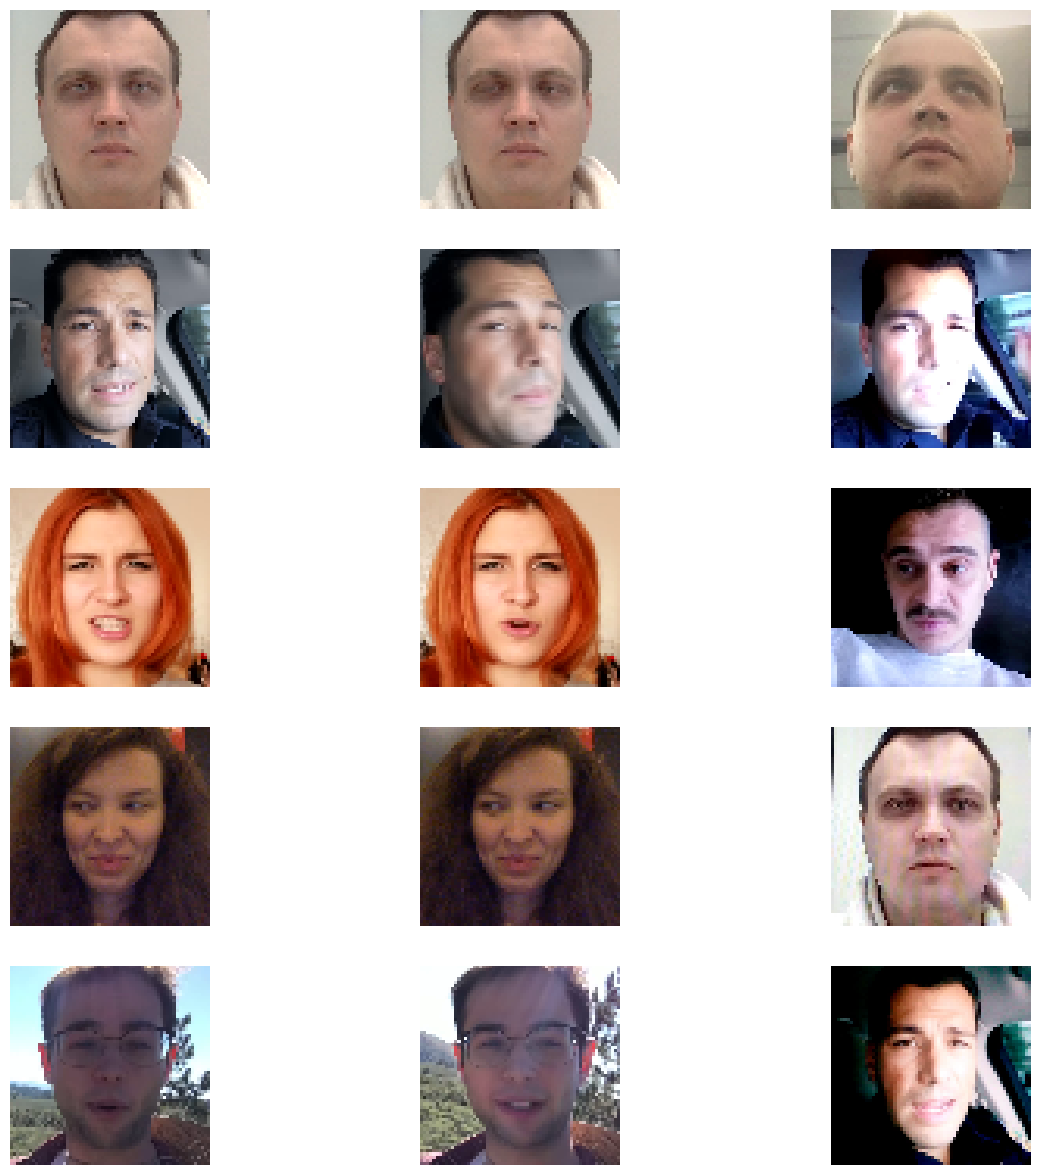

In [ ]:
# batch based processing with tensor.data
anchors, positives, negatives = next(iter(ds_train))
visualize_batch(anchors, positives, negatives, n=5)

In [ ]:
# https://www.digitalocean.com/community/tutorials/global-pooling-in-convolutional-neural-networks

base_cnn = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=DIM+(3,),
    pooling=None,
    classes=4000,
    classifier_activation='softmax'
)


# base_cnn = tf.keras.applications.ResNet50(
#     weights="imagenet", input_shape=DIM + (3,), include_top=False
# )

from tensorflow.keras import Model, layers

x = layers.GlobalAveragePooling2D()(base_cnn.output) #globalaveragepooling is used in cnn with great effect
x = layers.Dense(512, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(64)(x)
# https://stackoverflow.com/questions/59596162/how-to-apply-l2-normalization-to-a-layer-in-keras
output = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(x)

embedding = Model(base_cnn.input, output, name="Embedding")

trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable

embedding.summary()

Model: "Embedding"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 70, 70, 3) │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 32, 32,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 32, 32,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 32, 32,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 34, 34,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 16, 16,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 16, 16,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 16, 16,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 16, 16,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 16, 16,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 16, 16,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 16, 16,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 16, 16,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 16, 16,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 16, 16,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 16, 16,    │      1,024 │ conv2_block1_3_c

 Total params: 24,812,864 (94.65 MB)

 Trainable params: 10,154,688 (38.74 MB)

 Non-trainable params: 14,658,176 (55.92 MB)

In [ ]:
pp_in = tf.keras.applications.resnet.preprocess_input
ops = tf.keras.ops
class DistanceLayer(layers.Layer):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = ops.sum(tf.square(anchor - positive), -1)
        an_distance = ops.sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


anchor_input = layers.Input(name="anchor", shape=DIM + (3,))
positive_input = layers.Input(name="positive", shape=DIM + (3,))
negative_input = layers.Input(name="negative", shape=DIM + (3,))

distances = DistanceLayer()(
    embedding(pp_in(anchor_input)),
    embedding(pp_in(positive_input)),
    embedding(pp_in(negative_input)),
)

siamese_network = Model(inputs=[anchor_input, positive_input, negative_input], outputs=distances)

https://www.tensorflow.org/addons/api_docs/python/tfa/losses/TripletSemiHardLoss

In [ ]:
metrics = tf.keras.metrics
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super().__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.

        #tape records a sequence of events used to find _compute_loss(data)
        #this will be used to go back through the gradient and calculate the
        #differnce between the results,
        #mathematicly its using the chain rule to compute the changes in weights
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            #creates iterating tupples
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        # this is euclian distance between 3, or triplet loss
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        # this is euclian distance between 3, or triplet loss
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss
        # return tfa.losses.TripletSemiHardLoss(data,margin=margin)


    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

In [ ]:
siamese_model = SiameseModel(siamese_network, margin=.2) # smaller margin due to feature space similariry(neagtives are human faces)
siamese_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4))
# siamese_model.fit(ds_train, epochs=10, validation_data=ds_val)

In [ ]:
# assuming you flattened your dict into train_paths and val_paths lists:
batch_size = 32

# total number of triplets
train_samples = len(ds_val)
val_samples   = len(val_paths) # i want less here

# how many batches per epoch so you cover every sample once
steps_per_epoch   = train_samples // batch_size
validation_steps  = val_samples   // batch_size

print(f"Training on {train_samples} samples → {steps_per_epoch} steps/epoch")
print(f"Validating on {val_samples} samples → {validation_steps} steps/epoch")

siamese_model.fit(
    ds_train,
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    validation_data=ds_val,
    validation_steps=validation_steps
)


Training on 282 samples → 8 steps/epoch
Validating on 9 samples → 0 steps/epoch
Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 173s 22s/step - loss: 0.1232 - val_loss: 0.0175
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 107s 15s/step - loss: 0.0158 - val_loss: 0.0107
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 107s 15s/step - loss: 0.0128 - val_loss: 0.0084
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 107s 15s/step - loss: 0.0075 - val_loss: 0.0057
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 107s 15s/step - loss: 0.0051 - val_loss: 0.0043
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 109s 15s/step - loss: 0.0019 - val_loss: 0.0030
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 107s 15s/step - loss: 0.0046 - val_loss: 0.0035
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 149s 21s/step - loss: 0.0057 - val_loss: 0.0052
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 107s 15s/step - loss: 0.0055 - val_loss: 0.0047
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 108s 15s/step - loss: 0.0058 - val_loss: 0.0043


In [ ]:
from keras.applications import resnet

anchor, positive, negative = next(iter(ds_train))
# setting the embeding for each of A P and N
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(resnet.preprocess_input(anchor)),
    embedding(resnet.preprocess_input(positive)),
    embedding(resnet.preprocess_input(negative)),
)

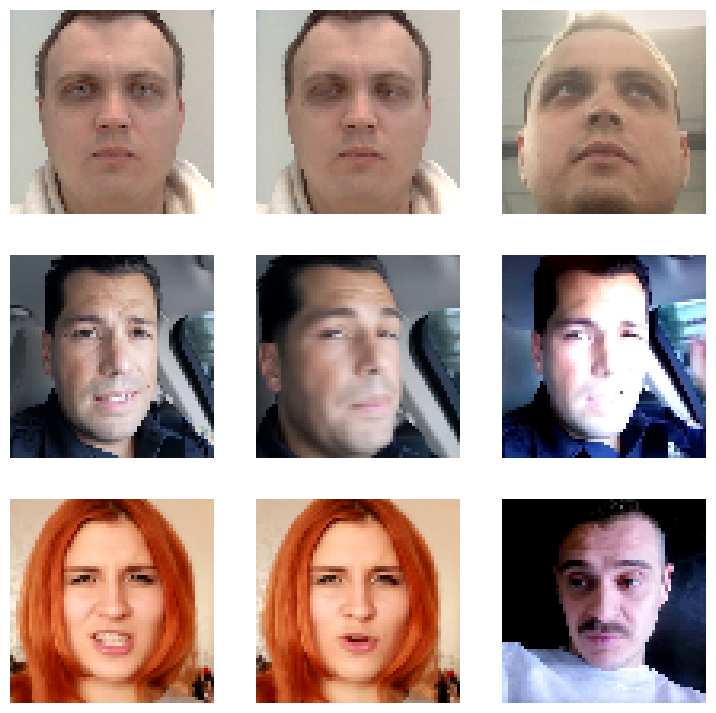

In [ ]:
visualize_batch(anchors, positives, negatives, n=3)

In [ ]:
cosine_similarity = metrics.CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Cosine Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Cosine Negative similarity", negative_similarity.numpy())

Cosine Positive similarity: 0.99685305
Cosine Negative similarity 0.7924088


margin .2 with 10 epoch    
Cosine Positive similarity: 0.99685305  
Cosine Negative similarity 0.7924088  

Indicates that margin may be to wide, data set is pretty similar (the negatives are other faces NOT things that look like faces.)  
Try to train on 0.1 or 0.2 margin

In [ ]:
# higher similarity is higher

In [ ]:
# def euclidean_disance_mean(set_x,set_y):
#   total = 0
#   count = 0
#   for x, y in zip(set_x,set_y):
#     total += tf.norm(x-y)
#     count += 1
#   mean = total/count
#   return mean

# There is a slight difference, it may be more effcient to use?
def euclidean_distance_mean(set_x, set_y):
    distances = tf.norm(set_x - set_y, axis=1)
    return tf.reduce_mean(distances)


positive_similarity = euclidean_distance_mean(anchor_embedding, positive_embedding)
print("Euclidean Positive similarity:", positive_similarity.numpy())

negative_similarity = euclidean_distance_mean(anchor_embedding, negative_embedding)
print("Euclidean Negative similarity", negative_similarity.numpy())

Euclidean Positive similarity: 0.07235691
Euclidean Negative similarity 0.88083166


.2 margin with 5 epoch

Euclidean Positive similarity: 0.07235691
Euclidean Negative similarity 0.88083166

Good result, Positives are closer then negatives

Mine:  
Euclidean Positive similarity: 0.41533336  
Euclidean Negative similarity 0.63670325

TF:  
Euclidean Positive similarity: 0.41533333  
Euclidean Negative similarity 0.63670325

Epoch 1/10
4689/4689 ━━━━━━━━━━━━━━━━━━━━ 526s 111ms/step - loss: 0.3740 - val_loss: 0.3988
Epoch 2/10
2542/4689 ━━━━━━━━━━━━━━━━━━━━ 3:47 106ms/step - loss: 0.3773

KeyboardInterrupt: 

Training on 150067 samples → 4689 steps/epoch
Validating on 4000 samples → 125 steps/epoch
Epoch 1/10
4689/4689 ━━━━━━━━━━━━━━━━━━━━ 4856s 1s/step - loss: 0.4406 - val_loss: 0.4144
Epoch 2/10
4689/4689 ━━━━━━━━━━━━━━━━━━━━ 1508s 322ms/step - loss: 0.3978 - val_loss: 0.4134
Epoch 3/10
4689/4689 ━━━━━━━━━━━━━━━━━━━━ 920s 196ms/step - loss: 0.3910 - val_loss: 0.4253
Epoch 4/10
4689/4689 ━━━━━━━━━━━━━━━━━━━━ 706s 151ms/step - loss: 0.3890 - val_loss: 0.4015
Epoch 5/10
4689/4689 ━━━━━━━━━━━━━━━━━━━━ 657s 140ms/step - loss: 0.3823 - val_loss: 0.3948
Epoch 6/10
4689/4689 ━━━━━━━━━━━━━━━━━━━━ 600s 128ms/step - loss: 0.3832 - val_loss: 0.4005
Epoch 7/10
4689/4689 ━━━━━━━━━━━━━━━━━━━━ 554s 118ms/step - loss: 0.3783 - val_loss: 0.4024
Epoch 8/10
4689/4689 ━━━━━━━━━━━━━━━━━━━━ 541s 115ms/step - loss: 0.3805 - val_loss: 0.4042
Epoch 9/10
4689/4689 ━━━━━━━━━━━━━━━━━━━━ 535s 114ms/step - loss: 0.3774 - val_loss: 0.3972
Epoch 10/10
4689/4689 ━━━━━━━━━━━━━━━━━━━━ 523s 112ms/step - loss: 0.3783 - val_loss: 0.4126
<keras.src.callbacks.history.History at 0x7d2d7e5de350>


In [ ]:
# batch size, DIM, col channels
siamese_model.build((batch_size, 64, 64, 3))

siamese_model.save_weights(data_url+"/siamese_spoofing_weights_m2.weights.h5")
siamese_model.save(data_url+"/siamese_spoofing_full_m2.keras")

needs to run on l4 to compute

ref: https://www.baeldung.com/cs/euclidean-distance-vs-cosine-similarity  
Cosine Similarity: angular distace bewteen 2 vectors in vector space, where the angles, where the circles centre is at the origin.  
Euclidean distance:the distance between 2 vectors in vector space  
L2_norm is messuing from the diffrence between the origin and the vector, but its the same equasion as euclidean

plot ROC & PR AUC: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

I'll use cosin similarity to classify the images using the mean = 0.87437755 as my threshold

In [ ]:
from sklearn.metrics import roc_curve, auc
import numpy as np

# on a per pair basis
def cosine_similarity_pairs(a, b):
    a = tf.math.l2_normalize(a, axis=0)
    b = tf.math.l2_normalize(b, axis=0)
    return tf.reduce_sum(a * b).numpy()

positive_scores = []
negative_scores = []

for a, p in zip(anchor_embedding, positive_embedding):
    score = cosine_similarity_pairs(a, p)
    positive_scores.append(score)

for a, n in zip(anchor_embedding, negative_embedding):
    score = cosine_similarity_pairs(a, n)
    negative_scores.append(score)

labels = [1] * len(positive_scores) + [0] * len(negative_scores)
scores = positive_scores + negative_scores


This is kind of crazy resut, i can;t believe that ts getting it all right, it
must be smal set, with some over fitting. Either way its a good result just abut skeptical

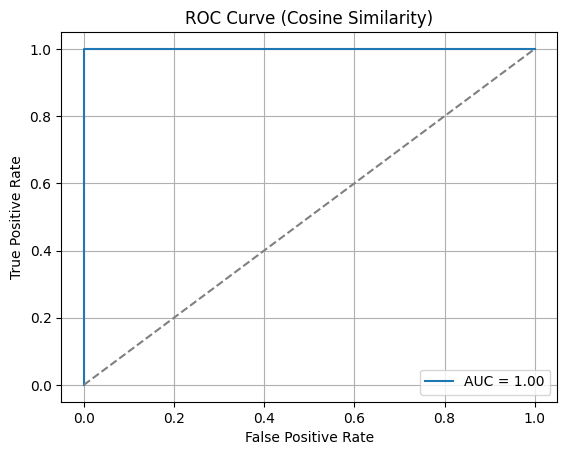

In [ ]:
fpr, tpr, thresholds = roc_curve(labels, scores)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color='gray')  # baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Cosine Similarity)")
plt.legend()
plt.grid(True)
plt.show()


Model is showing that it will likely produce true positives, its higher then  the middle line which is somewhat of a coin flip, since the AUC is .7 the  accuracy is about 70%

In [ ]:
!pip install tf2onnx

INFO: pip is looking at multiple versions of onnx to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 138.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 13.0 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully uninstalled protobuf-5.29.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.17.1 requires protobuf<6.0.0,>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.
ydf 0.11.0 requires protobuf<6.0.0,>=5.29.1, but you have protobuf 3.20.3 which is incompatible.
grpcio-status 1.71.0 requires protobuf<6.0d

In [ ]:
siamese_model = SiameseModel(siamese_network, margin=0.5)
siamese_model.build((tf.zeros((1,64,64,3)),
                   tf.zeros((1,64,64,3)),
                   tf.zeros((1,64,64,3))))
embedding = siamese_model.siamese_network.get_layer("Embedding")

In [ ]:
import tf2onnx
import onnx

input_signature = [tf.TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32)]
onnx_model, _ = tf2onnx.convert.from_keras(embedding, input_signature, opset=13)
onnx.save(onnx_model, data_url+"/embedding_spoof.onnx")

ERROR:tf2onnx.tfonnx:rewriter <function rewrite_constant_fold at 0x7a9afcf6f380>: exception `np.cast` was removed in the NumPy 2.0 release. Use `np.asarray(arr, dtype=dtype)` instead.
